### Importing libraries and defining the PDE model of CICR

In [7]:
"""
1. Detailed comments about model implementation can be found within 1D-CICR-model-v0.ipynb

2. The notebook contains imports of data generated using Latin Hypercube Sampling of the model parameters. The code 
   for doing LHS can be found within parameter-screening directory.
   
3. The notebook contains plots for Figure 5 and Supplementary Figure 10 of the manuscript
"""

import os
import time
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import pearsonr
from scipy.stats import t
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import seaborn as sns
import numba
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from smt.sampling_methods import LHS

@numba.njit
def release_calcium(t, t_i, sigma, tau, dSites):
    if t >= t_i and t <= t_i + tau:
        return sigma
    else:
        return 0
    
@numba.njit
def source_calcium(t, src_strength, src_rise_time):
    if t <= src_rise_time:
        return src_strength
    else:
        return 0
    
@numba.njit
def cicr_ros_diff(Ca, dx, dt, time_steps, theta):
    src_center_strength = theta[0]
    src_center_actTime = theta[1]
    sigma = theta[2] 
    tau = theta[3] 
    d_sites = theta[4]
    Ca_threshold = theta[5]
    D = 1200
    Ca_basal = 0.1
    Ca = Ca + Ca_basal
    
    L = 700
    points2 = np.arange(350+d_sites, 600, d_sites)
    points1List = []
    temp = 350
    for i in range(len(points2)):
        temp = temp - d_sites
        points1List.append(temp)
    points1Numpy = np.array(points1List)
    points1 = points1Numpy[::-1]
    x_sites = np.concatenate((points1, points2))
    ## Uncomment and switch the lines below if not using numba
    fired = np.zeros(len(x_sites), dtype=numba.boolean) ## np.zeros(len(x_sites), dtype=bool)
    fired_init_times = np.zeros(len(x_sites)) 
    
    idx_center = int(350 / dx)
    
    for t in range(1, time_steps): 
        ### Solving for diffusion
        Ca[1:-1, t] = Ca[1:-1, t-1] + D * dt / dx**2 * (Ca[2:, t-1] - 2 * Ca[1:-1, t-1] + Ca[:-2, t-1])
        Ca[0, t] = Ca_basal
        Ca[-1, t] = Ca_basal
        
        ### Defining source at center 
        Ca[idx_center,t]+= dt*source_calcium(t*dt, src_center_strength, src_center_actTime)
        
        ### Incorporating CICR
        for i, x_i in enumerate(x_sites):
            idx = int(x_i / dx)
            if not fired[i] and Ca[idx, t-1] >= Ca_threshold:
                fired[i] = True  
                fired_init_times[i] = t * dt    
            if fired[i]:
                Ca[idx, t] += dt* release_calcium(t*dt, fired_init_times[i], sigma, tau, d_sites)
                
    return Ca, x_sites, fired_init_times, fired, points2

def plotting_functions(Ca, x_sites, fired_init_times, ctr):
    
    Ca_size_in_gb = Ca.nbytes / (1024 ** 3) 
    memory_threshold_gb = 1.0
    
    if np.all(np.isfinite(Ca)):
        
        ### Creating directory to save files
        output_folder = 'output_data_analysis'
        os.makedirs(output_folder, exist_ok=True)
        
        ### Plotting figure
        fig, axs = plt.subplots(1, 1, figsize=(3, 3.5), dpi=200)
        Ca_sliced = Ca[:, ::100]
        
        half_index = Ca_sliced.shape[0] // 2
        Ca_sliced_half = Ca_sliced[half_index:, :]
        
        im1 = axs.imshow(Ca_sliced_half, extent=[0, 4, 350, 700], aspect='auto', origin='lower', interpolation='nearest')
        fig.colorbar(im1, ax=axs, label=r'$[Ca^{2+}]$')
        
        time_points1 = np.linspace(0, 2.81, 100)
        y_positions1 = 53.4 * time_points1 + 350
        axs.plot(time_points1, y_positions1, 'r-', linewidth=2)
        time_points2 = np.linspace(0, 1.43, 100)
        y_positions2 = 105.6 * time_points2 + 350
        axs.plot(time_points2, y_positions2, 'r-', linewidth=2)
        
        axs.scatter(fired_init_times, x_sites, c='tab:pink', s=10)
        
        axs.set_ylim(350, 700)
        axs.set_xlabel('Time (min)')
        axs.set_ylabel('Position (µm)')        
        filename = os.path.join(output_folder, 'Figure_' + str(ctr) + '.png')
        plt.tight_layout()
        plt.savefig(filename)
        plt.close(fig)
        
    else:
        print('Exceeds memory use!')
        

def main_model_1(theta, ctr):
    
    dx = 0.2 
    T = 4  
    dt = 0.00001  
    time_steps = int(T / dt)
    L = 700
    x = np.arange(0, L, dx)
    n = len(x)
    Ca = np.zeros((n, time_steps))
    
    ### Calling in the CICR model
    Ca, x_sites, fired_init_times, fired, points2 = cicr_ros_diff(Ca, dx, dt, time_steps, theta) 
    tau = theta[3]
    indices = np.where(np.isin(x_sites, points2))[0]
    filtered_fired = fired[indices]
    filtered_fired_init_times = fired_init_times[indices]
    
    ### Plotting functions
    if np.max(np.max(Ca)) < 100:
        fired_indices = np.where(filtered_fired)[0]
        if len(fired_indices) > 1:
            first_fired_index = fired_indices[np.argmin(filtered_fired_init_times[fired_indices])]
            last_fired_index = fired_indices[np.argmax(filtered_fired_init_times[fired_indices])]
            total_distance = points2[last_fired_index] - points2[first_fired_index]
            total_time = filtered_fired_init_times[last_fired_index] - filtered_fired_init_times[first_fired_index]
            average_velocity = total_distance / total_time if total_time != 0 else 10000
            yVar = points2[fired_indices]
            xVar = filtered_fired_init_times[fired_indices]
            slope, intercept, r_value, p_value, std_err = stats.linregress(xVar, yVar)
            y_pred = intercept + slope * xVar
            ss_res = np.sum((yVar - y_pred) ** 2) 
            ss_tot = np.sum((yVar - np.mean(yVar)) ** 2)  
            r_squared = 1 - (ss_res / ss_tot)
            """
            ### Uncomment this to enable plotting
            try:
                plotting_functions(Ca, x_sites, fired_init_times, ctr)
            except Exception as e:
                print('Not succesful in saving this one')"""
        else:
            average_velocity = 0
            total_distance = 0
            r_squared = 0
            
    else:
        average_velocity = 0
        total_distance = 0
        r_squared = 0
    
    return average_velocity, total_distance, r_squared

### Loading in master data generated by Latin Hypercube Sampling of model parameters.

The code for performing LHS of model parameters can be found within parameter-screening directory. 

In [8]:
### Contains a num_samples, num_parameters shaped numpy array of parametsr that were sampled 
theta_master = np.load('output-data-15000/theta_master.npy')
### Corresponding wave velocity computed using the model
wave_velocity_master = np.load('output-data-15000/wave_velocity_master.npy')

### Experimental data of wave velocity in um/min for 1um flg22 treatment
vel_exp = [53.4, 61.8, 62.4, 63.6, 74.4, 76.2, 84,
           84.6, 86.4, 90.6, 92.4, 97.8, 102, 105.6]

vel_min = min(vel_exp)
vel_max = max(vel_exp)

### Filtering out cases from LHS whose wave velocities lie within the experimental range
mask = (wave_velocity_master >= vel_min) & (wave_velocity_master <= vel_max)
wave_velocity_filtered = wave_velocity_master[mask]
### Converting back parametsr that were sampled in log scale.
theta_filtered = theta_master[mask]
theta_filtered[:, :4] = 10 ** theta_filtered[:, :4]
### A filtering out of solutions where the value of parameter tau (activation time of CICR channels) is less than half  minute
wave_velocity_subset = wave_velocity_filtered[theta_filtered[:, 3] <= 0.5]
theta_filtered_subset = theta_filtered[theta_filtered[:, 3] <= 0.5]

"""
The code below was first run and then we filtered out qualitatively using the kymographs
solutions that resemble the experimental data more accurately.Such cases are filtered using 
manually defined list indices_cicr_pos
"""

"""
average_velocity_master = []
total_distance_master = []  
r_squared_master = []

for i, theta in enumerate(theta_filtered_subset):
    average_velocity_temp, total_distance_temp, r_squared_temp = main_model_1(theta, i)
    average_velocity_master.append(average_velocity_temp)
    total_distance_master.append(total_distance_temp)
    r_squared_master.append(r_squared_temp)
    print(i)
"""

### Indicating indices whose wave profile qualitatively resembles teh expewrimental data. 
### (See comments on commented code above)
indices_cicr_pos = [12, 33, 36, 48, 89, 91, 99,
                    103, 174, 187, 198, 217, 226, 243,
                    317, 324, 331, 332]

theta_filtered_subset = theta_filtered_subset[indices_cicr_pos,:]
wave_velocity_subset = wave_velocity_subset[indices_cicr_pos]

### Supplementary figure 10B

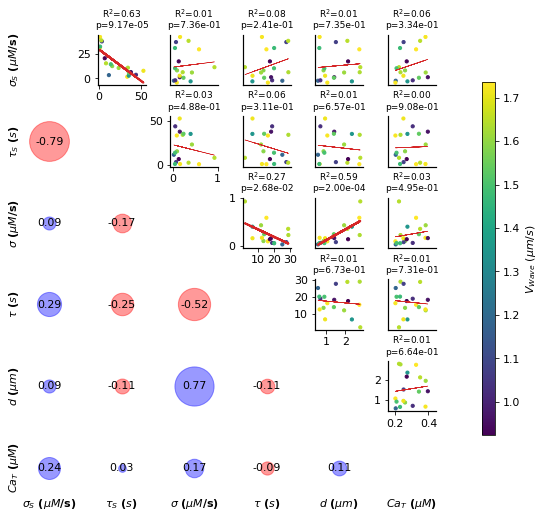

In [9]:
"""
This part of the code is used to compute the correlation betwen parameters
using the data generated in LHS. The correlation is estimated using only those parametsr values 
that generate wave velocities within the experimental ranges as observed within data of 1uM flg22 treatment. 
"""

### Supressing warning messages generating during plotting
warnings.filterwarnings("ignore", 
                        category=UserWarning, 
                        message=".*tight_layout.*")

### Converting the time sscale of parameters to seconds for plotting
data = theta_filtered_subset.copy()
data[:, 0] = data[:, 0] / 60 # sigma_S, uM/min -> uM/s
data[:, 2] = data[:, 2] / 60 # sigma, uM/min -> uM/s
data[:, 1] = data[:, 1] * 60 # tau_S, min -> s
data[:, 3] = data[:, 3] * 60 # tau, min -> s
wave_velocity_subset = wave_velocity_subset / 60 ## wave velocity, um/min -> um/s

### Defining properties for plots
vmin, vmax = wave_velocity_subset.min(), wave_velocity_subset.max()
norm = Normalize(vmin=vmin, vmax=vmax)
colormap = cm.viridis
labels = [r'$\sigma_{S}$ ($\mu M$/s)', r'$\tau_{S}$ ($s$)', r'$\sigma$ ($\mu M$/s)', r'$\tau$ ($s$)',
          r'$d$ ($\mu m$)', r'$Ca_{T}$ ($\mu M$)']

fig, axes = plt.subplots(6, 6, figsize=(6, 7))
for i in range(6):
    for j in range(6):
        if i < j:
            ### Plotting the ith and ith parameter values of teh filtered solutions as a scatter plot
            scatter = axes[i, j].scatter(data[:, j], data[:, i], c=wave_velocity_subset, cmap=colormap, norm=norm, s=10)
            if j > i + 1:
                axes[i, j].set_xticks([])
                axes[i, j].set_yticks([])
            X = data[:, j].reshape(-1, 1)
            y = data[:, i]
            ### Fitting a line to teh model using regression
            model = LinearRegression().fit(X, y)
            y_pred = model.predict(X)
            ### Computing r-squared value
            r2 = r2_score(y, y_pred)
            ### Computing earson correlation coefficient to estimate correlation between parameters i and j 
            corr, p_value = pearsonr(data[:, j], data[:, i])
            ### Adding legends and labels to plots
            axes[i, j].plot(X, y_pred, color='tab:red', lw=2 if p_value < 0.05 else 0.5)
            axes[i, j].set_title(f'R$^2$={r2:.2f}\np={p_value:.2e}', fontsize=9)
            axes[i, j].spines['top'].set_visible(False)
            axes[i, j].spines['right'].set_visible(False)
            axes[i, j].spines['left'].set_linewidth(1.2)
            axes[i, j].spines['bottom'].set_linewidth(1.2)
        elif i > j:
            ### Adding teh pearson correlation coefficient as text in teh lower diagonal counterpart
            corr, _ = pearsonr(data[:, j], data[:, i])
            circle_size = abs(corr) * 2000  
            color = 'blue' if corr > 0 else 'red'
            axes[i, j].scatter(0.5, 0.5, s=circle_size, color=color, alpha=0.4)
            axes[i, j].text(0.5, 0.5, f'{corr:.2f}', ha='center', va='center', fontsize=11, color='black')
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            axes[i, j].spines['top'].set_visible(False)
            axes[i, j].spines['right'].set_visible(False)
            axes[i, j].spines['left'].set_visible(False)
            axes[i, j].spines['bottom'].set_linewidth(False)
        else:
            axes[i, j].spines['top'].set_visible(False)
            axes[i, j].spines['right'].set_visible(False)
            axes[i, j].spines['left'].set_visible(False)
            axes[i, j].spines['bottom'].set_linewidth(False)
            axes[i, j].set_yticks([])
            axes[i, j].set_xticks([])
        axes[i, 0].set_ylabel(labels[i], fontsize=11, fontweight='bold')
        axes[5, i].set_xlabel(labels[i], fontsize=11, fontweight='bold')
cbar_ax = fig.add_axes([1.1, 0.15, 0.03, 0.7]) 
fig.colorbar(scatter, cax=cbar_ax, label=r'$V_{Wave}$ ($\mu m/s$)', norm = norm)
plt.tight_layout(pad=0.005)
plt.show()

**Supplementary Figure 10B** *Correlation analysis of the parameter values for the best-fitting parameters. The upper diagonal shows scatter plots of each parameter pair, color-coded by wave velocity. The line of best fit is overlaid in red color, with the R2 value indicated above each plot. The lower diagonal shows the Pearson correlation coefficients, represented by circles. The size and color of each circle correspond to the strength and direction of the correlation: red for negative and blue for positive correlations.*

### Figure 5A

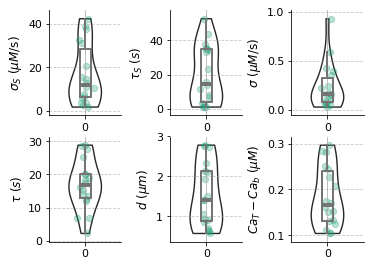

In [10]:
"""
The code is used to visualzie the distribution of parameter values that generate wave velocities as observed 
within the experimenatal data
"""

### Parameter labels
labels_param = [r'$\sigma_{S}$ ($\mu M$/s)', r'$\tau_{S}$ ($s$)', r'$\sigma$ ($\mu M$/s)', r'$\tau$ ($s$)',
                r'$d$ ($\mu m$)', r'$Ca_{T}-Ca_{b}$ ($\mu M$)']

BLACK = "#282724"
GREY_DARK = "#747473"
COLOR_SCALE = ["#1B9E77", "#D95F02", "#7570B3", "#E7298A", "#66A61E", "#E6AB02"]
jitter = 0.04

### Defining figure layout
fig, axes = plt.subplots(2, 3, figsize=(5, 3.5))
plt.rcParams.update({'font.size': 11})

### Position of box plot within the x axis
POSITIONS = [0]  

### Iterating through all teh parameters
for idx, ax in enumerate(axes.flat):
    ### Fetching teh parametr values
    a = theta_filtered_subset[:, idx].copy()
    ### Setting up teh units of timescale from minutes to seconds
    if idx == 0 or idx == 2: #sigma_s, sigma: uM/min -? uM/s 
        a = a/60
    elif idx == 1 or idx == 3: #tau_s, tau: min -> s
        a = a*60
    elif idx == 5:
        a = a - 0.1 #Ca_T: ca_T - ca_b
        
    y_data = [a]
    
    ### Plotting teh violinn plot 
    violins = ax.violinplot(
        y_data, 
        positions=POSITIONS,
        widths=0.45,
        bw_method="silverman",
        showmeans=False, 
        showmedians=False,
        showextrema=False
    )

    for pc in violins["bodies"]:
        pc.set_facecolor("none")
        pc.set_edgecolor(BLACK)
        pc.set_linewidth(1.4)
        pc.set_alpha(1)
    
    ### Plotting the box plot
    medianprops = dict(linewidth=4, color=GREY_DARK, solid_capstyle="butt")
    boxprops = dict(linewidth=2, color=GREY_DARK)
    ax.boxplot(
        y_data,
        positions=POSITIONS, 
        showfliers=False, 
        showcaps=False,   
        medianprops=medianprops,
        whiskerprops=boxprops,
        boxprops=boxprops
    )
    
    ### Creating a scatter of actual data-points over the overlaid box and violin plots
    x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
    x_jittered = [x + t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
    ax.scatter(x_jittered[0], y_data[0], s=40, alpha=0.3, color=COLOR_SCALE[0])
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel(labels_param[idx], fontsize=12)
    ax.grid(True)

plt.tight_layout(pad = 0.005)
plt.show()

**Figure 5A** *Experimentally measured wave velocities for 1 µM flg22 treatment were used to define the experimental range. Latin Hypercube Sampling was employed to estimate the parameters of a 1D CICR wave model for which wave velocities fell within the experimental range. A combination of box and violin plots illustrates the distribution of different estimated parameters. The box represents the interquartile range (IQR), while the whiskers extend to 1.5 times the IQR. The horizontal line within the box marks the median.*

### Supplementary figure 10A

In [11]:
"""
Generating data for supplementary figure 10A by decreasing parameter sigma. In this code we decrease teh value of
sigma in all the filtered  parameter values by 15% and 30%. For it, we measure and visualzi eteh change sin wave 
velocity and distance travelled by the wave
"""
### initialization of array of storing control metrics
wave_velocities_1 = np.zeros(len(theta_filtered_subset))
wave_distances_1 = np.zeros(len(theta_filtered_subset))
### initialization of array of storing metrics on a decrease of para,eter sigma by 15%
wave_velocities_2 = np.zeros(len(theta_filtered_subset))
wave_distances_2 = np.zeros(len(theta_filtered_subset))
### initialization of array of storing metrics on a decrease of para,eter sigma by 30%
wave_velocities_3 = np.zeros(len(theta_filtered_subset))
wave_distances_3 = np.zeros(len(theta_filtered_subset))

### Iterating over all the filtered solutions
for i, theta in enumerate(theta_filtered_subset):
    ### Creating a copy of teh parametr values
    theta_1 = theta.copy()
    theta_2 = theta.copy()
    theta_3 = theta.copy()
    theta_1[2] *= 1 # Control case
    theta_2[2] *= 0.85 # Decrease sigma by 15%
    theta_3[2] *= 0.7 # Decrease sigma by 30%
    
    ### Solving teh model
    wave_vel_1, dis1, dummy1 = main_model_1(theta_1, ctr=0) 
    wave_vel_2, dis2, dummy2 = main_model_1(theta_2, ctr=0)
    wave_vel_3, dis3, dummy3 = main_model_1(theta_3, ctr=0)
    
    ### Storing teh wave velocities and travel distances. 
    wave_velocities_1[i] = wave_vel_1
    wave_velocities_2[i] = wave_vel_2
    wave_velocities_3[i] = wave_vel_3
    wave_distances_1[i] = dis1
    wave_distances_2[i] = dis2
    wave_distances_3[i] = dis3
    
print("Data is generated. Move to next step for plotting")

Data is generated. Move to next step for plotting


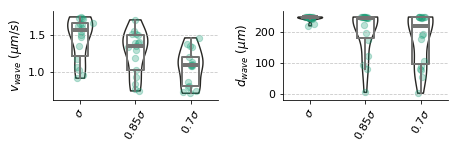

In [13]:
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

mask1 = wave_distances_1 >= 20
mask2 = wave_distances_2 >= 20
mask3 = wave_distances_3 >= 20

filtered_wave_velocities_1 = wave_velocities_1[mask1]
filtered_wave_velocities_2 = wave_velocities_2[mask2]
filtered_wave_velocities_3 = wave_velocities_3[mask3]

fig, ax = plt.subplots(1,2,figsize=(6.6, 2.2))
plt.rcParams.update({'font.size': 11})
POSITIONS = [0,1,2]

x_label = (r'$\sigma$',
           r'$0.85\sigma$',
           r'$0.7\sigma$'
          )

"""
Plot for wave velocity
"""
a = (filtered_wave_velocities_1.copy()) / 60
b = (filtered_wave_velocities_2.copy()) / 60
c = (filtered_wave_velocities_3.copy()) / 60
means = [np.mean(arr[arr != 0]) for arr in [a, b, c]]
min_non_zero = np.min([np.min(arr[arr != 0]) for arr in [a, b]])

y_data = [a, b, c]

violins = ax[0].violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    
medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax[0].boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, 
    showcaps = False,   
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)    

jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
COLOR_SCALE = ["#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77",
               "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77"]
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax[0].scatter(x, y, s=40, alpha=0.3, color=color)
ax[0].set_xlabel('')
ax[0].set_ylabel(r'$v_{wave}$ ($\mu m/s$)', fontsize = 12)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xticklabels(x_label, rotation=60)

"""
Plot for distance travelled by wave
"""
a = (wave_distances_1.copy()) 
b = (wave_distances_2.copy()) 
c = (wave_distances_3.copy()) 
means = [np.mean(arr[arr != 0]) for arr in [a, b, c]]
min_non_zero = np.min([np.min(arr[arr != 0]) for arr in [a, b]])

y_data = [a, b, c]

violins = ax[1].violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    
medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax[1].boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, 
    showcaps = False,   
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)    

jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
COLOR_SCALE = ["#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77",
               "#1B9E77", "#1B9E77", "#1B9E77", "#1B9E77"]
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax[1].scatter(x, y, s=40, alpha=0.3, color=color)
ax[1].set_xlabel('')
ax[1].set_ylabel(r'$d_{wave}$ ($\mu m$)', fontsize = 12)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xticklabels(x_label, rotation=60)

plt.tight_layout()
plt.show()

**Supplementary Figure 10A** *For each parameter set that produced wave velocities within the experimental range (Figure 5A), the parameter σ was reduced by 15% and 30%, shown on the x-axis. A box-and-whisker plot displays the distribution of (i) wave velocities and (ii) wave propagation distances resulting from these reductions in σ. The box spans the interquartile range (IQR), with whiskers extending to 1.5 times the IQR, and the horizontal line within the box indicates the median.* 